1. **Define dataset file paths**

In [104]:
import pandas as pd
import pyarrow.parquet as pq
import torch
from torch_geometric.data import Data
train_path = "/Users/a1234/Documents/Personal Files/PHD Applications/KIT Germany/molgnn_project/train-00000-of-00001.parquet"
val_path   = "/Users/a1234/Documents/Personal Files/PHD Applications/KIT Germany/molgnn_project/validation-00000-of-00001.parquet"
test_path  = "/Users/a1234/Documents/Personal Files/PHD Applications/KIT Germany/molgnn_project/test-00000-of-00001.parquet"

2. **Load parquet files (NO pandas)**

What??

Load QM9 data using PyArrow, not pandas.

Why??

Pandas fails on nested molecular structures (as you saw).

In [105]:
train_table = pq.read_table(train_path)
val_table   = pq.read_table(val_path)
test_table  = pq.read_table(test_path)

In [106]:
print("Train molecules:", train_table.num_rows)
print("Validation molecules:", val_table.num_rows)
print("test molecules:", test_table.num_rows)

Train molecules: 110000
Validation molecules: 10000
test molecules: 10831


3. **Understand ONE molecule structure**

What??

Inspect a single molecule row.

Why?

You must understand what a graph looks like.

In [107]:
row = {col: train_table.column(col)[0].as_py() for col in train_table.column_names}

In [108]:
row.keys()

dict_keys(['mol_id', 'x', 'z', 'pos', 'edge_index', 'edge_attr', 'smiles', 'y'])

4. **Interpret graph components (CRITICAL)**

| QM9 column   | Graph meaning         |
| ------------ | --------------------- |
| `x`          | Node features (atoms) |
| `z`          | Atomic numbers        |
| `pos`        | 3D coordinates        |
| `edge_index` | Graph connectivity    |
| `edge_attr`  | Bond features         |
| `y`          | Molecular properties  |


In [109]:
print("Node features shape:", len(row['x']), "nodes")
print("Edge index shape:", len(row['edge_index']), "x ?")
print("Target properties:", len(row['y']))

Node features shape: 21 nodes
Edge index shape: 2 x ?
Target properties: 19


In [110]:
print("3D coordinates:", len(row['pos']))
print("edge_attrs:", len(row['edge_attr']))

3D coordinates: 21
edge_attrs: 46


5. **Convert ONE molecule into PyG Data**

What

Turn a molecule into a graph object.

Why

PyTorch Geometric works ONLY with Data objects.

In [111]:
data = Data(
    x=torch.tensor(row['x'], dtype=torch.float),
    pos=torch.tensor(row['pos'], dtype=torch.float),
    edge_index=torch.tensor(row['edge_index'], dtype=torch.long),
    edge_attr=torch.tensor(row['edge_attr'], dtype=torch.float),
    y=torch.tensor(row['y'], dtype=torch.float)
)

print(data)


Data(x=[21, 11], edge_index=[2, 46], edge_attr=[46, 4], y=[19], pos=[21, 3])


6. **Choose ONE prediction target**

What??

Select one molecular property.

Why??

Focus > complexity (very important academically).

We’ll predict property index 0 (e.g. dipole moment

In [112]:
TARGET_INDEX = 0

data.y = data.y[TARGET_INDEX]
print("Target value:", data.y)


Target value: tensor(0.4889)


7. **Create conversion function (clean design)**

What??

Reusable function to convert rows → graphs.

Why??

Good ML engineering practice.

In [20]:
def row_to_data(row, target_idx=0):
    return Data(
        x=torch.tensor(row['x'], dtype=torch.float),
        pos=torch.tensor(row['pos'], dtype=torch.float),
        edge_index=torch.tensor(row['edge_index'], dtype=torch.long),
        edge_attr=torch.tensor(row['edge_attr'], dtype=torch.float),
        y=torch.tensor(row['y'][target_idx], dtype=torch.float)
    )

8. **Convert full datasets**

What??

Create graph datasets for training & validation.

Why??

Now we have a true GNN dataset.

In [113]:
def table_to_dataset(table, limit=None):
    data_list = []
    n = table.num_rows if limit is None else limit
    
    for i in range(n):
        row = {col: table.column(col)[i].as_py() for col in table.column_names}
        data_list.append(row_to_data(row))
    
    return data_list

train_data = table_to_dataset(train_table, limit=1000)  # limit for speed
val_data   = table_to_dataset(val_table, limit=200)

print(len(train_data), len(val_data))


1000 200


9. **Use DataLoader (graph batching)**

What??

Batch graphs for training.

Why??

GNNs train on many small graphs, not one big graph

In [114]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32)

In [115]:
train_loader

In [116]:
val_loader

# Build GNN model

**Import GNN layers**

In [117]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

**Lets define the GNN model**

In [118]:
class MolecularGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        
        # Message passing layers (atom ↔ atom)
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        # Final prediction head
        self.lin = nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # x: atom features
        # edge_index: bond connections
        # batch: which atom belongs to which molecule
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        # Pool atom embeddings → molecule embedding
        x = global_mean_pool(x, batch)
        
        #  Predict molecular property
        return self.lin(x)


**Lets create model instance**

In [119]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MolecularGCN(
    in_channels=train_data[0].x.shape[1],
    hidden_channels=128
).to(device)

print(model)
print(device)

MolecularGCN(
  (conv1): GCNConv(11, 128)
  (conv2): GCNConv(128, 128)
  (lin): Linear(in_features=128, out_features=1, bias=True)
)
cpu


**Forward pass sanity check**

In [120]:
batch = next(iter(train_loader))

out = model(
    batch.x,
    batch.edge_index,
    batch.batch
)

print("Model output shape:", out.shape)

Model output shape: torch.Size([32, 1])


# Training the GNN

**Select the target property**

In [121]:
#TARGET_IDX = 0  # e.g. dipole moment

In [122]:
target = batch.y.view(-1, 1)

**select Loss & optimizer**

In [123]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

**Learning rate scheduler**

In [124]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=True
)

**Training loop**

def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for batch in loader:
        batch = batch.to(device)  # ensure data is on the same device
        optimizer.zero_grad()

        pred = model(batch.x, batch.edge_index, batch.batch)
        target = batch.y.view(-1, 1)  # for single-target regression

        loss = criterion(pred, target)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

        optimizer.step()

        total_loss += loss.item() * batch.num_graphs

    return total_loss / len(loader.dataset)

In [127]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        pred = model(batch.x, batch.edge_index, batch.batch)
        target = batch.y.view(-1, 1)  # single-target regression

        loss = criterion(pred, target)  # ✅ use criterion here
        loss.backward()

        # Optional: gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

        optimizer.step()
        total_loss += loss.item() * batch.num_graphs

    return total_loss / len(loader.dataset)


**Evaluation loop**

In [128]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index, batch.batch)
            target = batch.y.view(-1, 1)

            loss = criterion(pred, target)
            total_loss += loss.item() * batch.num_graphs

    return total_loss / len(loader.dataset)

**Run training**

In [129]:
batch = next(iter(train_loader))
print(batch.y.shape)

torch.Size([32])


In [130]:
EPOCHS = 50
train_losses, val_losses = [], []

for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss = evaluate(model, val_loader, criterion, device)

    scheduler.step(val_loss)  # ✅ pass metric here

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(
        f"Epoch {epoch:02d} | "
        f"Train MSE: {train_loss:.4f} | "
        f"Val MSE: {val_loss:.4f} | "
        f"LR: {current_lr:.6f}"
    )


Epoch 01 | Train MSE: 4.1093 | Val MSE: 1.9784 | LR: 0.001000
Epoch 02 | Train MSE: 1.8613 | Val MSE: 1.8389 | LR: 0.001000
Epoch 03 | Train MSE: 1.8479 | Val MSE: 1.7791 | LR: 0.001000
Epoch 04 | Train MSE: 1.8268 | Val MSE: 1.7270 | LR: 0.001000
Epoch 05 | Train MSE: 1.7964 | Val MSE: 1.7213 | LR: 0.001000
Epoch 06 | Train MSE: 1.7894 | Val MSE: 1.8006 | LR: 0.001000
Epoch 07 | Train MSE: 1.7759 | Val MSE: 1.6885 | LR: 0.001000
Epoch 08 | Train MSE: 1.7585 | Val MSE: 1.6605 | LR: 0.001000
Epoch 09 | Train MSE: 1.7560 | Val MSE: 1.6691 | LR: 0.001000
Epoch 10 | Train MSE: 1.8008 | Val MSE: 1.6575 | LR: 0.001000
Epoch 11 | Train MSE: 1.7524 | Val MSE: 1.7052 | LR: 0.001000
Epoch 12 | Train MSE: 1.7580 | Val MSE: 1.6925 | LR: 0.001000
Epoch 13 | Train MSE: 1.7740 | Val MSE: 1.6479 | LR: 0.001000
Epoch 14 | Train MSE: 1.7468 | Val MSE: 1.6543 | LR: 0.001000
Epoch 15 | Train MSE: 1.7403 | Val MSE: 1.6479 | LR: 0.001000
Epoch 16 | Train MSE: 1.7278 | Val MSE: 1.6728 | LR: 0.001000
Epoch 17

In [131]:
# Ensure model is on the correct device
model = model.to(device)
model.eval()

# Get one validation batch
batch = next(iter(val_loader))
batch = batch.to(device)

with torch.no_grad():
    pred = model(batch.x, batch.edge_index, batch.batch)

# Print a few predictions vs ground truth
print("Prediction:", pred[:5].view(-1))
print("Ground truth:", batch.y[:5].view(-1))


Prediction: tensor([3.1446, 2.4352, 2.4954, 2.6394, 3.7724])
Ground truth: tensor([4.4744, 3.0302, 3.1951, 3.0274, 4.0928])


In [43]:
EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, train_loader)
    val_loss = evaluate(model, val_loader)

    print(f"Epoch {epoch:02d} | Train MSE: {train_loss:.4f} | Val MSE: {val_loss:.4f}")

Epoch 01 | Train MSE: 4.5852 | Val MSE: 1.8538
Epoch 02 | Train MSE: 1.9507 | Val MSE: 1.8531
Epoch 03 | Train MSE: 1.8807 | Val MSE: 1.8242
Epoch 04 | Train MSE: 1.8643 | Val MSE: 1.8095
Epoch 05 | Train MSE: 1.8565 | Val MSE: 1.7976
Epoch 06 | Train MSE: 1.8468 | Val MSE: 1.7810
Epoch 07 | Train MSE: 1.8357 | Val MSE: 1.7712
Epoch 08 | Train MSE: 1.8171 | Val MSE: 1.7586
Epoch 09 | Train MSE: 1.8175 | Val MSE: 1.7385
Epoch 10 | Train MSE: 1.8017 | Val MSE: 1.7292


**Show a real prediction**

In [46]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


**Before Improvment**

In [50]:
model = model.to(device)

model.eval()
batch = next(iter(val_loader))
batch = batch.to(device)

with torch.no_grad():
    pred = model(batch.x, batch.edge_index, batch.batch)

print("Prediction:", pred[:5].view(-1))
print("Ground truth:", batch.y[:5])


Prediction: tensor([2.8886, 2.2663, 2.3655, 2.4724, 3.3539])
Ground truth: tensor([4.4744, 3.0302, 3.1951, 3.0274, 4.0928])


## Learning curve

**Pick ONE molecule from validation set**

In [132]:
# Get one batch
batch = next(iter(val_loader))

# Select first molecule in the batch
data = batch.get_example(0)

print(data)

Data(x=[16, 11], edge_index=[2, 34], edge_attr=[34, 4], y=[1], pos=[16, 3])


**Convert PyG graph → NetworkX graph bc PyTorch Geometric already supports this**

In [133]:
from torch_geometric.utils import to_networkx
import networkx as nx

G = to_networkx(data, to_undirected=True)

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


Nodes: 16
Edges: 17


**Plot the molecular graph (atoms & bonds)**

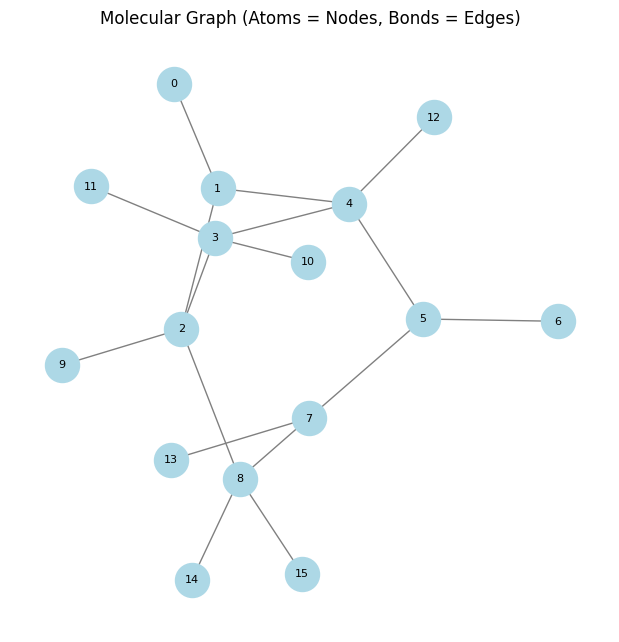

In [136]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=600,
    node_color="lightblue",
    edge_color="gray",
    font_size=8
)

plt.title("Molecular Graph (Atoms = Nodes, Bonds = Edges)")
plt.show()

**Add atom labels (C, H, O, N…)**

In [145]:
data.x

tensor([[0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

**Extract atomic numbers from x

We can safely use column 5 as atomic number:**

In [148]:
atomic_numbers = data.x[:, 5].long()
print(atomic_numbers)

tensor([8, 6, 6, 6, 6, 6, 8, 7, 6, 1, 1, 1, 1, 1, 1, 1])


**Map atomic numbers → symbols**

In [149]:
ATOM_MAP = {
    1: "H",
    6: "C",
    7: "N",
    8: "O",
    9: "F"
}

labels = {i: ATOM_MAP[int(num)] for i, num in enumerate(atomic_numbers)}
print(labels)


{0: 'O', 1: 'C', 2: 'C', 3: 'C', 4: 'C', 5: 'C', 6: 'O', 7: 'N', 8: 'C', 9: 'H', 10: 'H', 11: 'H', 12: 'H', 13: 'H', 14: 'H', 15: 'H'}


**Added atom labels**

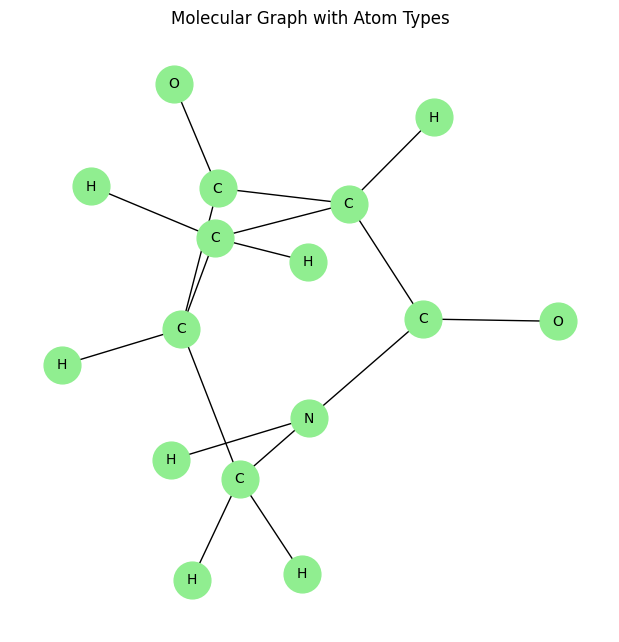

In [150]:
import matplotlib.pyplot as plt
import networkx as nx

# Suppose G is your molecule graph
plt.figure(figsize=(6, 6))
nx.draw(
    G,
    pos,
    labels=labels,
    node_size=700,
    node_color="lightgreen",
    edge_color="black",
    font_size=10
)
plt.title("Molecular Graph with Atom Types")
plt.show()


# XAI for Molecule using GNNExplainer

In [178]:
from torch_geometric.explain import GNNExplainer